In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path_db =  {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        path_db[filename.replace('.csv','')] = path
        
path = path_db['WA_Fn-UseC_-Telco-Customer-Churn']
df = pd.read_csv(path)

print(f'Data path: {path} - {df.shape}')

df.head()

Data path: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv - (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [4]:
# Utiliy Functions for Visualization
def boxplot_wannotation_plot(df: pd.DataFrame) -> None:
    num_columns = len(df.columns)
    num_rows = (num_columns // 3) + (num_columns % 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False,
                            meanline=True, showmeans =True, meanprops={'color': 'red', 'linestyle': '--'})
        ax.set_title(f'{col}')
        ax.set_xticks([])

        # Calculate the median and mean
        median, mean = df[col].median(), df[col].mean()

        # Mean and Median Annotation
        ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='green')
        ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='red')

        # Outlier calculation and Annotation
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    

def distribution_wannotation_plot(df: pd.DataFrame) -> None:
    num_features = len(df.columns) - 1
    num_rows,num_cols = 1, 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        ax = axes[i]
        # Plot All the data points
        sns.histplot(data=df, x=column, bins=20, common_norm=False, ax=ax,
                    legend=False, color='orange', alpha=0.2, edgecolor='none')

        # Plot the data points seperated by hue (Outcome)
        sns.histplot(data=df, x=column, bins=20, common_norm=False, kde=True,
                    ax=ax, legend=False, palette={0: 'blue', 1: 'red'}, alpha=0.4, edgecolor='none')

        mean = df[column].mean()
        var = df[column].var()
        skew = df[column].skew()

        ax.set_title(f'{column}\n(Mean={mean:.2f}, Var={var:.2f}, Skew={skew:.2f})')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

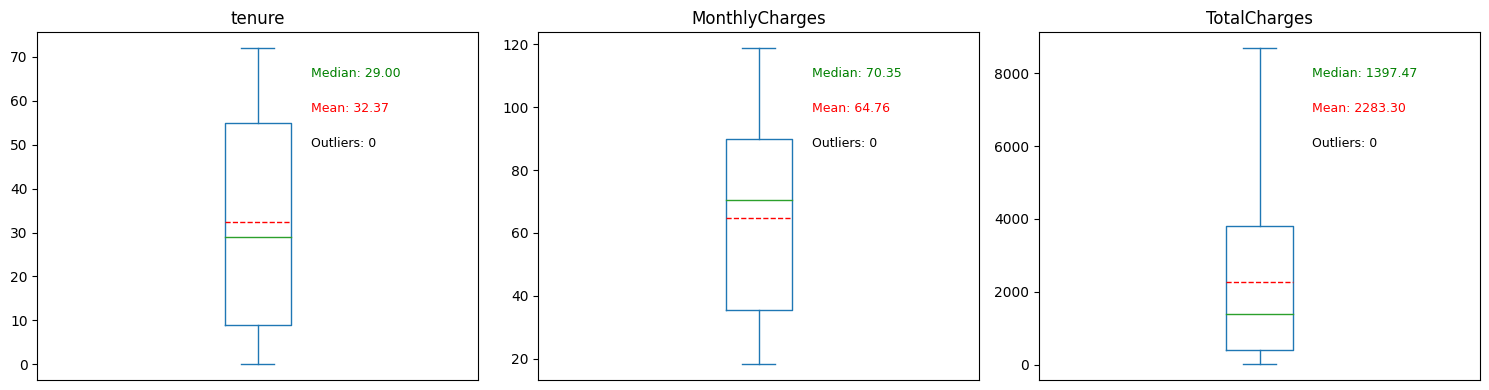

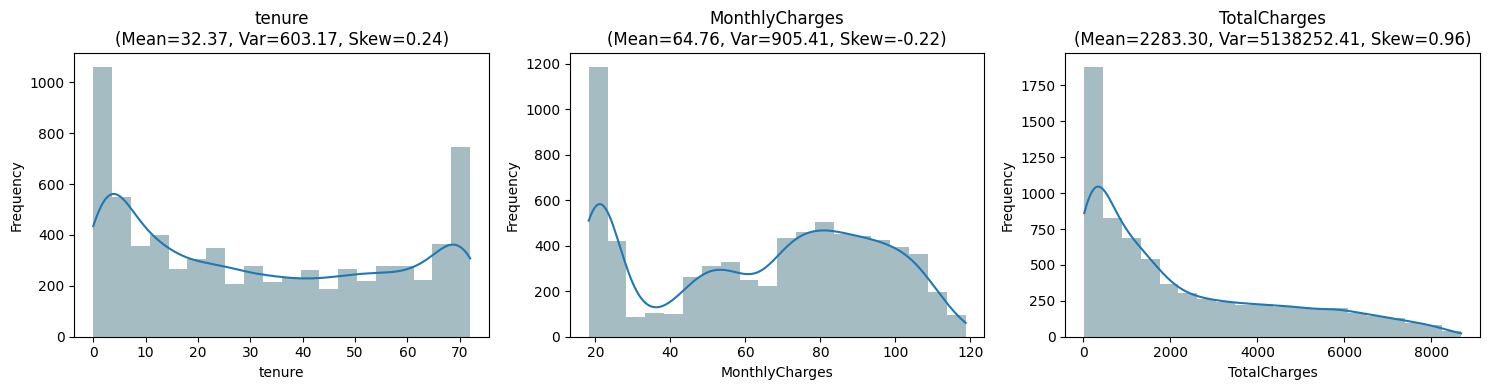

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
numerical_data_col = ['tenure','MonthlyCharges','TotalCharges']
boxplot_wannotation_plot(df[numerical_data_col])
distribution_wannotation_plot(df[numerical_data_col])

There is no outliers among the numerical data in the dataset; hence, we don't have to remove any outliers.

### Features Exploration and Engineering

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies. Columns that are associated with this features include: **'PhoneService', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies'**

In [6]:
sdf = df.iloc[:,1:]
telco_products = [
    'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# All Services 
sdf['AllServiceProportion'] = (
    sdf['PhoneService'].map({'Yes': 1, 'No': 0}) + 
    sdf['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0}) + 
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +  
    sdf['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 8

# Online Activity Services
sdf['OnlineProportion'] = (
    sdf['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0}) + 
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +   
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 5

# Protection Services 
sdf['ProtectionProportion'] = (
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 4

# Streaming Services
sdf['StreamingProportion'] = (
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 2

df = sdf.copy()

sdf.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AllServiceProportion,OnlineProportion,ProtectionProportion,StreamingProportion
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.25,0.4,0.25,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.50,No,0.50,0.4,0.50,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.50,0.6,0.50,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.50,0.4,0.75,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.25,0.2,0.00,0.0


### Preprocess Numerical Data

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Imputation (incase for missing values) based on the visualization
df['tenure'] = df['tenure'].fillna(df['tenure'].mean()) 
df['MonthlyCharges'] = df['MonthlyCharges'].fillna(df['MonthlyCharges'].mean()) 
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median()) 

# Need to perform Z-score Normalization on the numerical data
# Using Z-score Normalization because we DON'T know the possible Range 
znorm_scaler = StandardScaler()

# Using MinMaxScaler to make the data numerical dat within the same range as categorical of [0,1]??
minmax_scaler = MinMaxScaler(feature_range = (0,1))

numerical_data_col = ['tenure','MonthlyCharges','TotalCharges','AllServiceProportion','OnlineProportion','ProtectionProportion','StreamingProportion']
numerical_df = df[numerical_data_col]

transnumerical_data_col = [f'{col}_norm' for col in numerical_data_col]
# numerical_df[transnumerical_data_col] = znorm_scaler.fit_transform(numerical_df[numerical_data_col])
numerical_df[transnumerical_data_col] = minmax_scaler.fit_transform(numerical_df[numerical_data_col])
# MinMaxScaler because the features are right skewed and bimodal data distribution

numerical_df.head()

,tenure,MonthlyCharges,TotalCharges,AllServiceProportion,OnlineProportion,ProtectionProportion,StreamingProportion,tenure_norm,MonthlyCharges_norm,TotalCharges_norm,AllServiceProportion_norm,OnlineProportion_norm,ProtectionProportion_norm,StreamingProportion_norm
0,1,29.85,29.85,0.25,0.4,0.25,0.0,0.013889,0.115423,0.001275,0.142857,0.4,0.25,0.0
1,34,56.95,1889.50,0.50,0.4,0.50,0.0,0.472222,0.385075,0.215867,0.428571,0.4,0.50,0.0
2,2,53.85,108.15,0.50,0.6,0.50,0.0,0.027778,0.354229,0.010310,0.428571,0.6,0.50,0.0
3,45,42.30,1840.75,0.50,0.4,0.75,0.0,0.625000,0.239303,0.210241,0.428571,0.4,0.75,0.0
4,2,70.70,151.65,0.25,0.2,0.00,0.0,0.027778,0.521891,0.015330,0.142857,0.2,0.00,0.0


### Preprocess Categorical Data

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encoding the Categorical Data - including the Churn (Prediction Class)
categorical_df = df.drop(columns = numerical_data_col, axis = 1).iloc[:,1:]
original_categorical_columns = categorical_df.columns.tolist()

label_encoders = {}
label_to_original = {}

# Apply LabelEncoder to each feature and store the direct conversion in a dictionary
for column in categorical_df.select_dtypes(include=['object','int']).columns:
    le = LabelEncoder()
    categorical_df[column + '_Encoded'] = le.fit_transform(categorical_df[column])
    label_encoders[column] = le
    label_to_original[column] = dict(zip(le.transform(categorical_df[column]), categorical_df[column]))

encoded_columns = [col for col in categorical_df.columns if col.endswith('Encoded')]

categorical_df[encoded_columns].head()

,SeniorCitizen_Encoded,Partner_Encoded,Dependents_Encoded,PhoneService_Encoded,MultipleLines_Encoded,InternetService_Encoded,OnlineSecurity_Encoded,OnlineBackup_Encoded,DeviceProtection_Encoded,TechSupport_Encoded,StreamingTV_Encoded,StreamingMovies_Encoded,Contract_Encoded,PaperlessBilling_Encoded,PaymentMethod_Encoded,Churn_Encoded
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


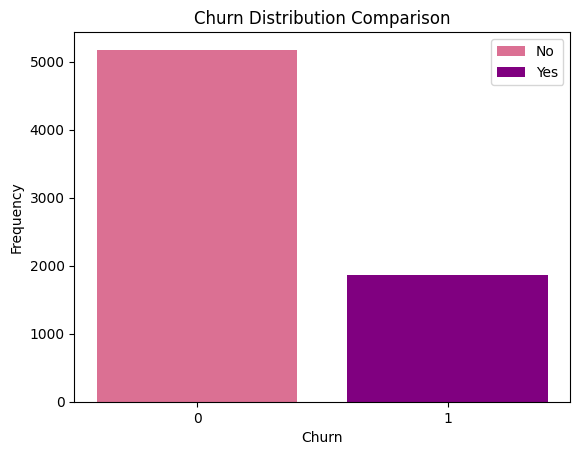

In [9]:
class_labels = label_to_original['Churn']
categorical_df['Churn_Label'] = categorical_df['Churn_Encoded'].map(class_labels)
value_counts = categorical_df['Churn_Encoded'].value_counts()

unique_values = value_counts.index
plt.bar(unique_values, value_counts, color=['palevioletred','purple'], tick_label=unique_values, label=class_labels.values())

plt.xlabel('Churn')
plt.ylabel('Frequency')
plt.title('Churn Distribution Comparison')
plt.legend()
plt.show()

We can clearly see the class imbalance between Churn and Not Churn. Therefore, we have to manipulation methods to increase the number of data

Original Data:
Churn: (1869, 23)
Not Churn: (5174, 23)

Upsample Data:
Churn: (5174, 23)
Not Churn: (5174, 23)

Final Data: (10348, 23)


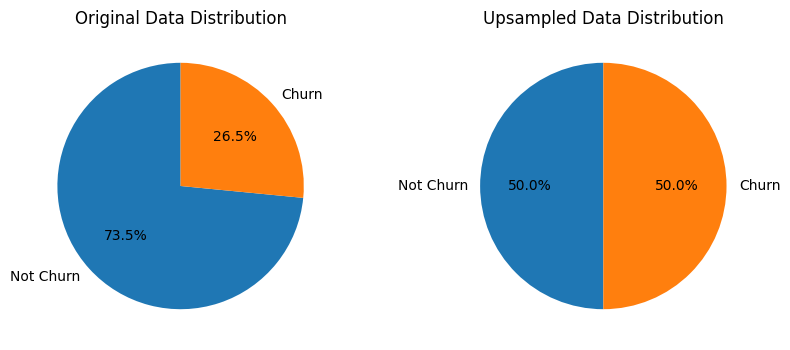

In [10]:
from sklearn.utils import resample

X = pd.concat([categorical_df[encoded_columns], numerical_df[transnumerical_data_col]], axis = 1) # Still contain the prediction class

X_Churn, X_NChurn = X[X['Churn_Encoded'] == 1], X[X['Churn_Encoded'] == 0]
print(f'Original Data:\nChurn: {X_Churn.shape}\nNot Churn: {X_NChurn.shape}\n')

X_Churn_upsample = resample(
    X_Churn,
    replace=True,
    n_samples=len(X_NChurn),
    random_state=0
)
print(f'Upsample Data:\nChurn: {X_Churn_upsample.shape}\nNot Churn: {X_NChurn.shape}\n')

X_upsample = pd.concat([X_NChurn, X_Churn_upsample], axis=0)
print(f'Final Data: {X_upsample.shape}')

# Plot visualization for Original and Upsampled Data
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

original_distribution = X.groupby('Churn_Encoded').size()
axes[0].pie(original_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Original Data Distribution')

upsampled_distribution = X_upsample.groupby('Churn_Encoded').size()
axes[1].pie(upsampled_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Upsampled Data Distribution')

plt.show()

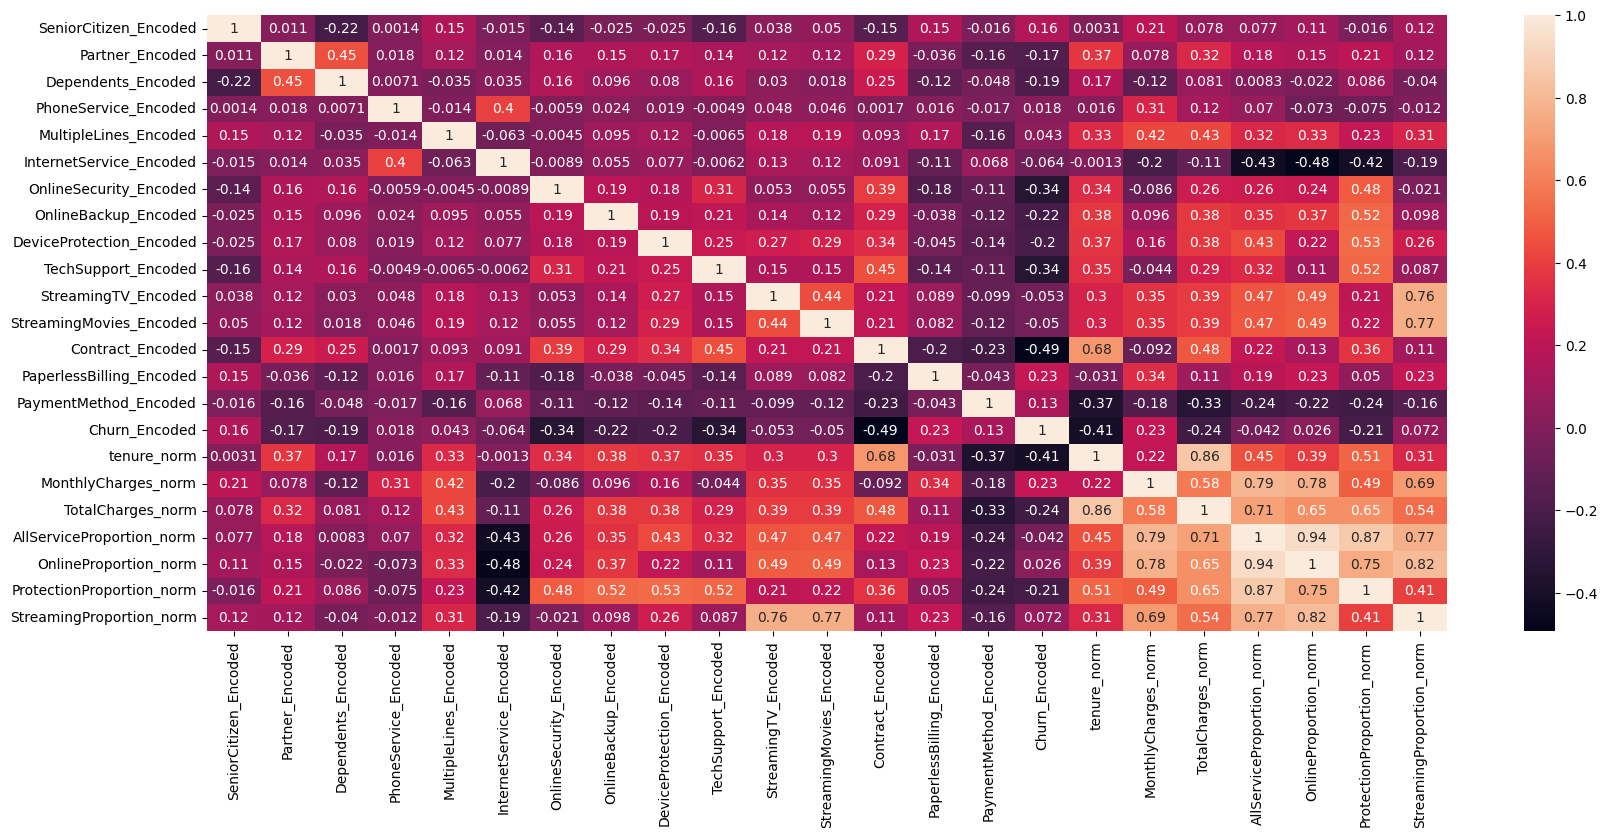

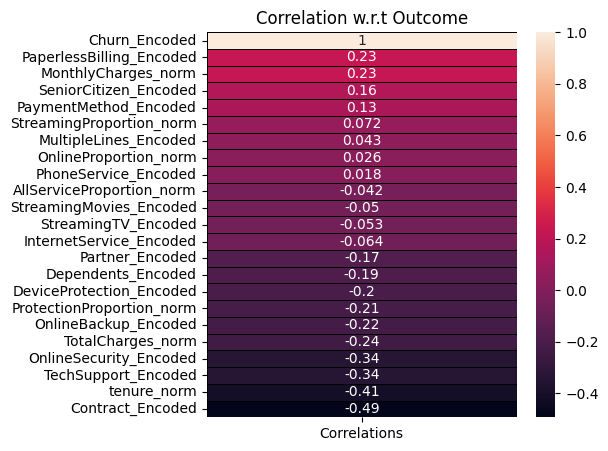

In [11]:
# Correlation via Heatmap
plt.figure(figsize = (20,8))
sns.heatmap(X_upsample.corr(), cmap = 'rocket', annot = True)
plt.show()

# Correlation with respect to Churn (Encoded)
corr = X_upsample.corrwith(X_upsample['Churn_Encoded']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True, cmap = 'rocket',linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');

The featurse with correlation between **[-0.1, 0.1]** will be removed from the dataset, considering that it has relatively week correlation. The remaining features would either display a significant positive or negative correlation

Text(0.5, 1.0, 'Selection of Categorical Features')

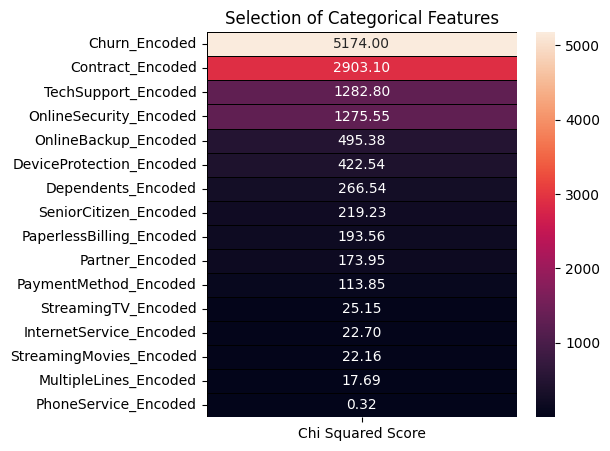

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif

# Using Chi-square test to find important features for origical categorical data
categorical_features = encoded_columns
features = X_upsample.loc[:,categorical_features]
target = X_upsample.loc[:,'Churn_Encoded']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = 'rocket',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features')

Based on the Chi-squared Test, the features StreamingTV_Encoded, InternetService_Encoded, StreamingMovies_Encoded, MultipleLines_Encoded, and PhoneService_Encoded have low Chi-squared score. Hence, they will not be included as training features for the model.

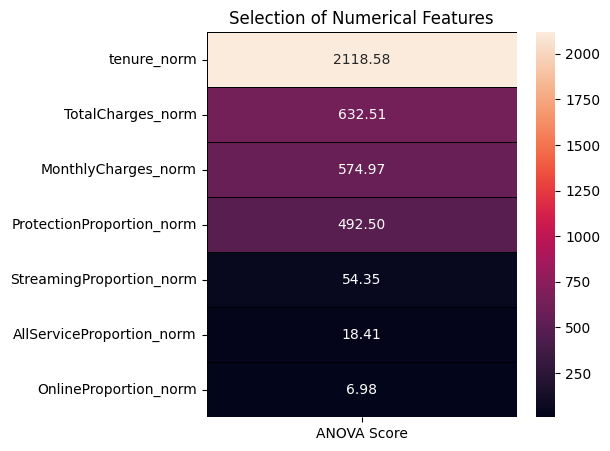

In [13]:
from sklearn.feature_selection import f_classif

numerical_features = transnumerical_data_col
features = X_upsample.loc[:,numerical_features]
target = X_upsample.loc[:,'Churn_Encoded']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = 'rocket',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

Based on the ANOVA test, higher the value of the ANOVA score indicate the higher importance of the features. Given the result from the ANOVA test, we can eleminate the last three features including: StreamingProportion_norm, AllServiceProportion_norm, and OnlineProportion_norm

In [14]:
drop_categorical_features = [
    'StreamingTV_Encoded', 'InternetService_Encoded', 'StreamingMovies_Encoded', 'MultipleLines_Encoded', 'PhoneService_Encoded'
]

drop_numerical_features = [
    'StreamingProportion_norm', 'AllServiceProportion_norm','OnlineProportion_norm'
]

X_upsample = X_upsample.drop(drop_categorical_features, axis=1)
X_upsample = X_upsample.drop(drop_numerical_features, axis=1)
X_upsample.shape

(10348, 15)

In [15]:
X_upsample.shape

(10348, 15)

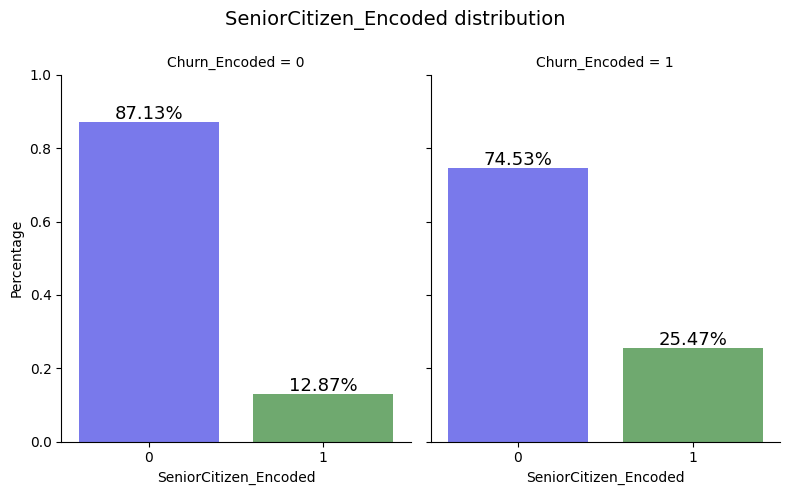

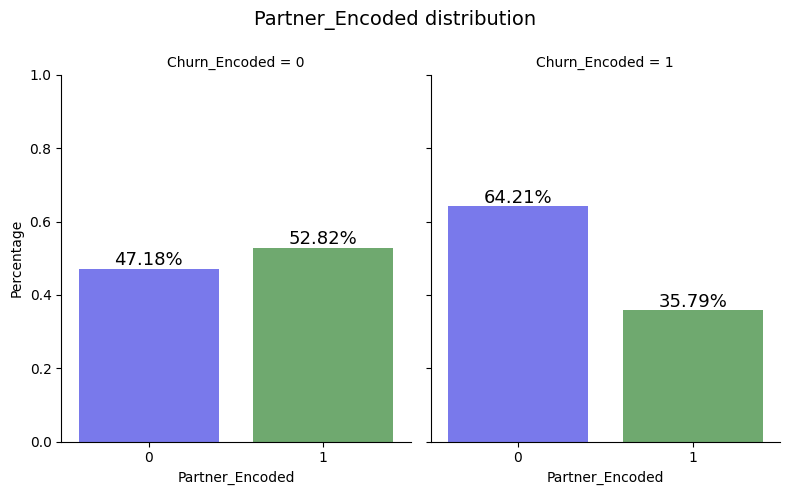

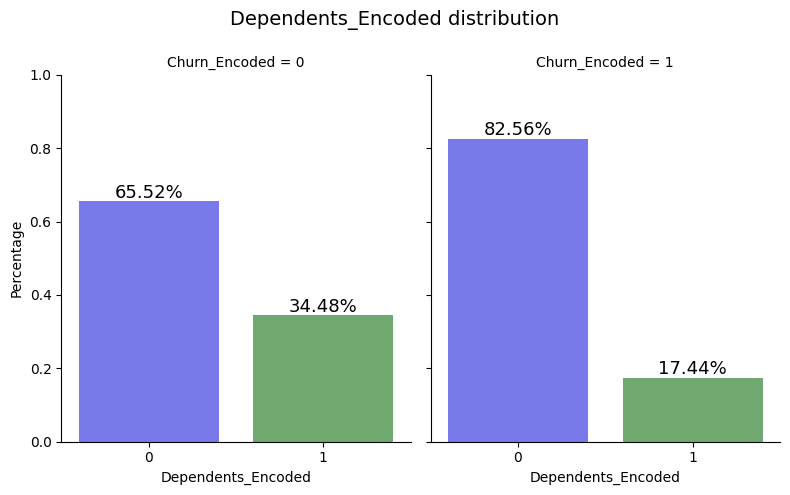

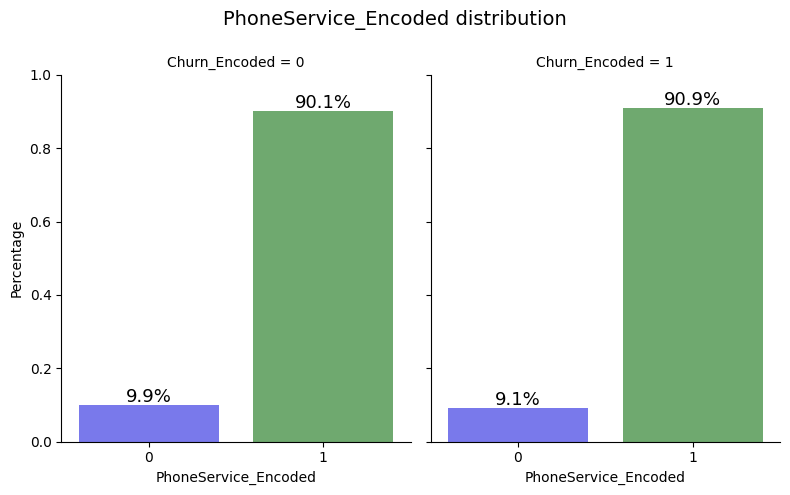

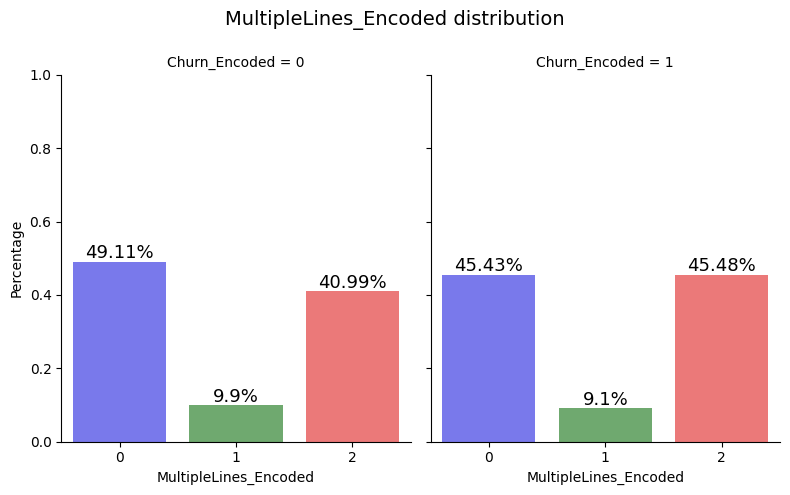

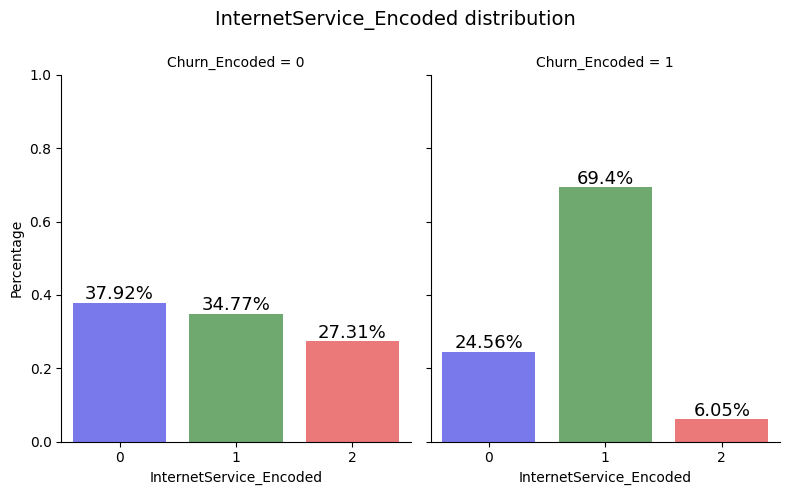

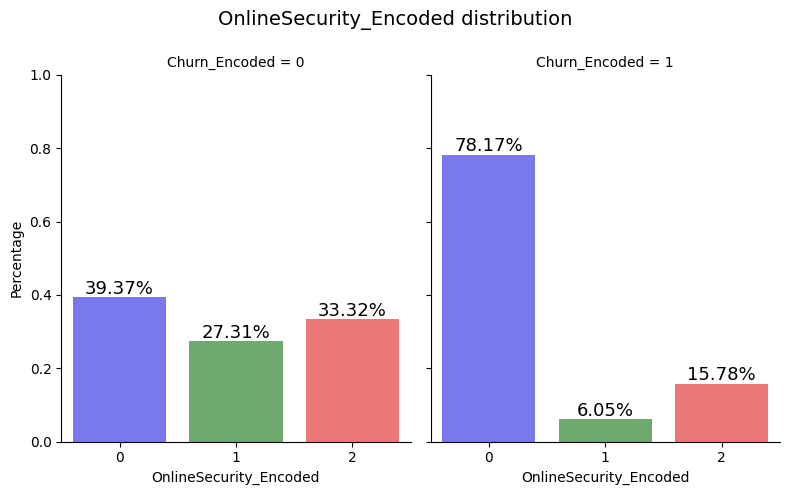

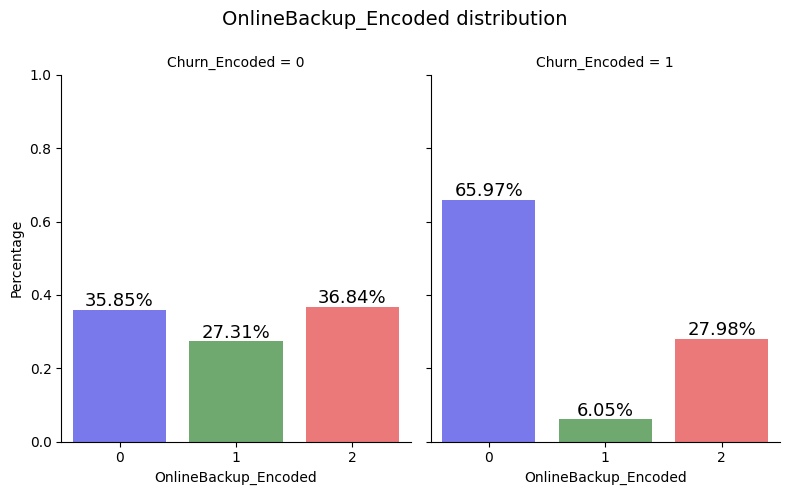

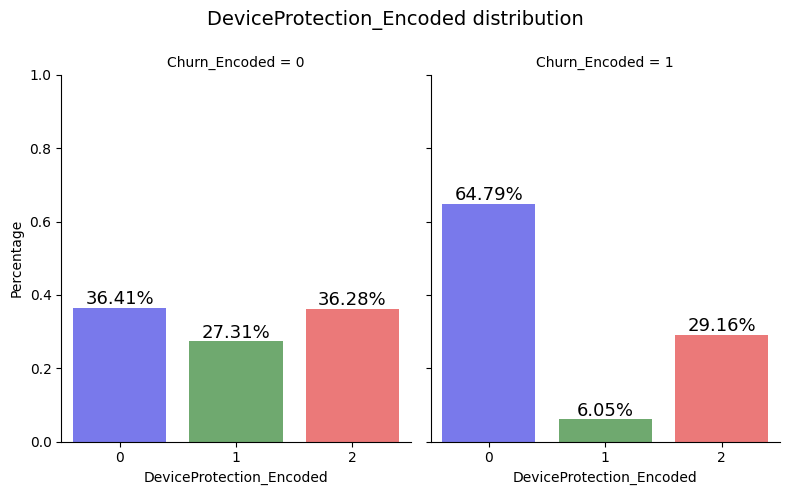

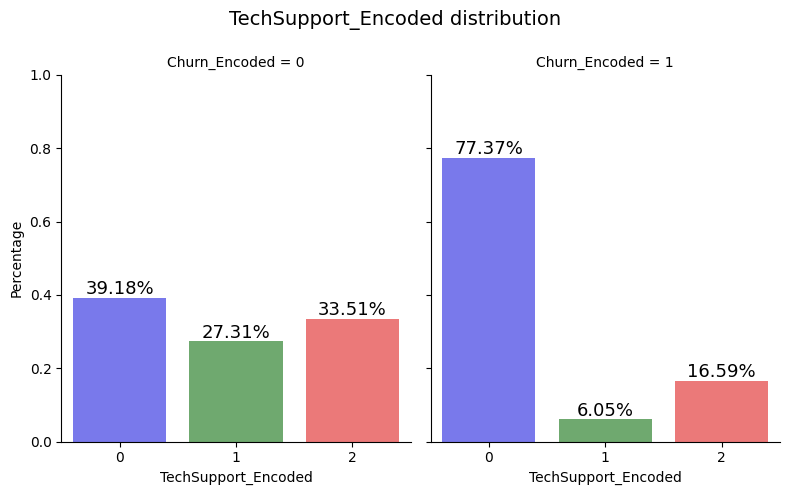

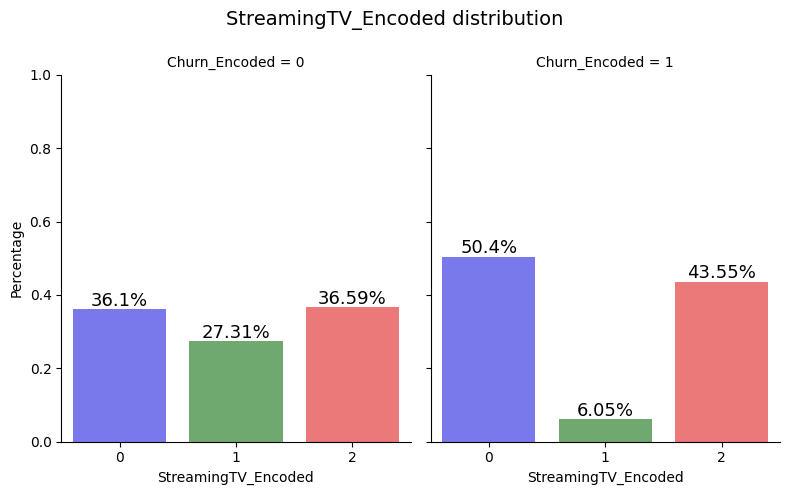

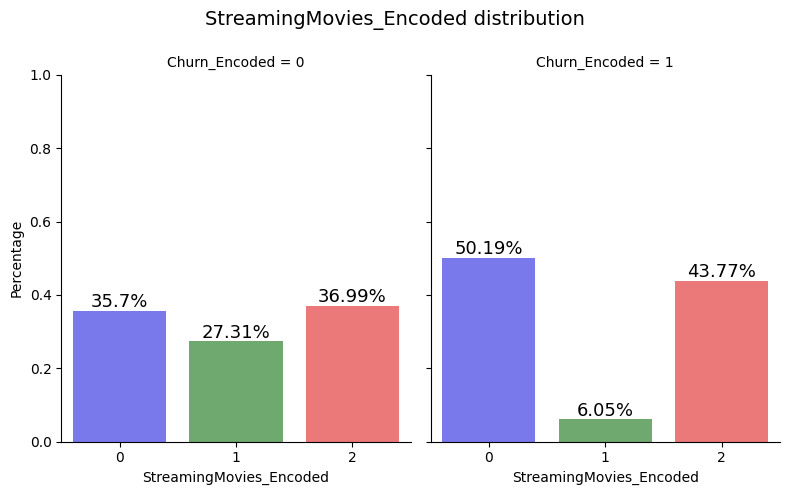

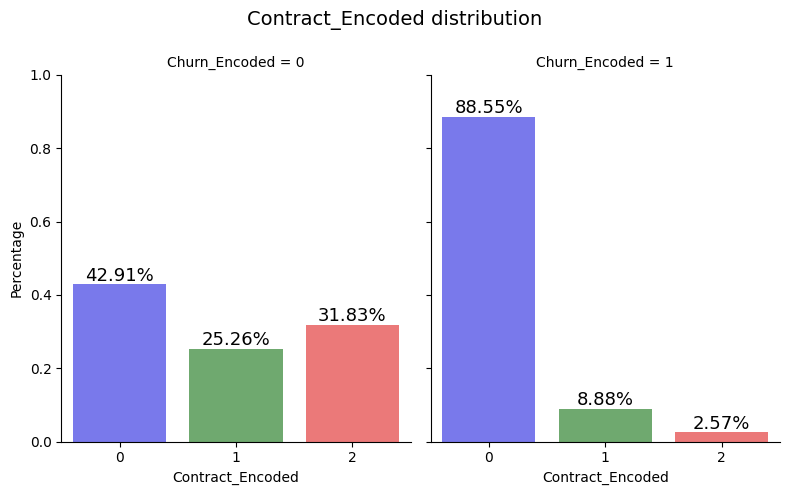

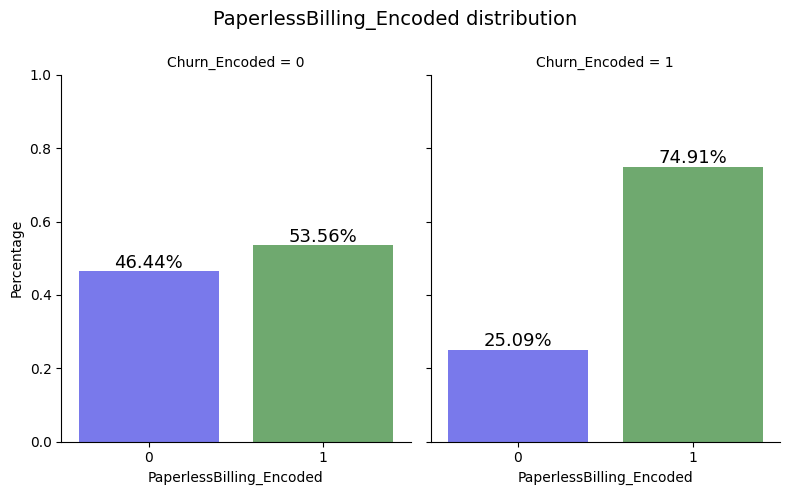

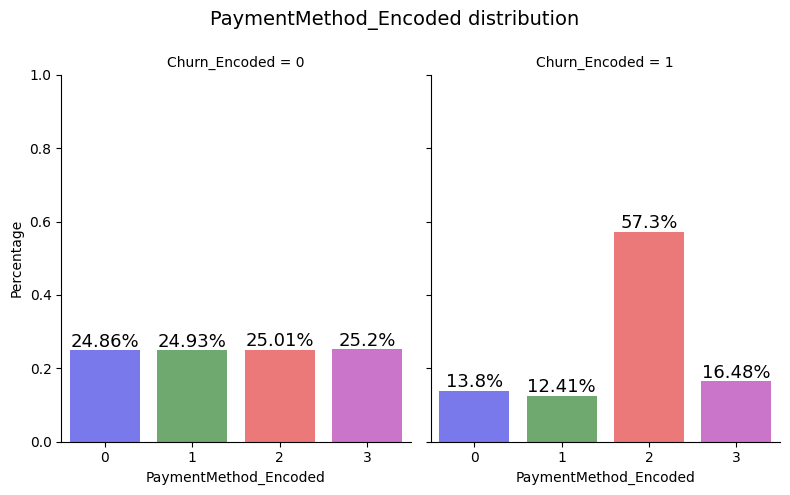

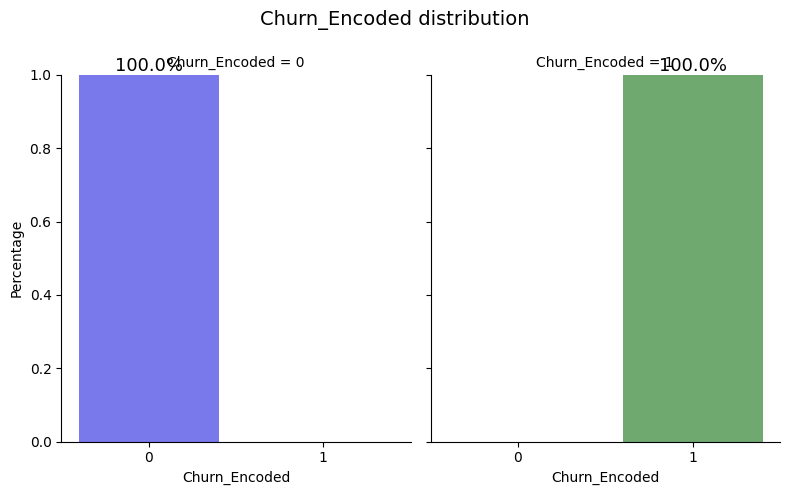

In [16]:
def create_data_label(ax):
    """ Display data label for given axis """
    for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/ 2
                    , bar.get_height() + 0.01
                    , str(round(100 * bar.get_height(),2)) + '%'
                    , ha = 'center'
                    , fontsize = 13)
            
            
def categorical_var_churn_dist(data, cols, distribution_col):
    """ Distribution of categorical variable based on target variable """
    
    for i,feature in enumerate(cols):
        
        feature_summary = data[feature].value_counts(normalize=True).reset_index(name='Percentage')
        
        plt_cat = sns.catplot(x=feature
                , y='Percentage'
                , data = feature_summary
                , col=distribution_col
                , kind='bar'
                , aspect = 0.8
                , palette = plotColor
                , alpha = 0.6)
        
        if feature == 'PaymentMethod':
            plt_cat.set_xticklabels(rotation= 65, horizontalalignment = 'right')
        
        
        for ax1, ax2 in plt_cat.axes:
            create_data_label(ax1)
            create_data_label(ax2)
        
        plt.ylim(top=1)
        plt.subplots_adjust(top = 0.85)
        plt.gcf().suptitle(feature+" distribution",fontsize=14)
    plt.show()

plotColor = ['b','g','r','m','c', 'y']
churn_summary = X.groupby('Churn_Encoded')
categorical_var_churn_dist(churn_summary, encoded_columns,'Churn_Encoded')

# Model Development

1. Prepare training and testing data
2. Model Selection: select three based classification models
3. Model Construction: implement new classification model architecture
4. Train the models
5 .

In [17]:
from sklearn.model_selection import train_test_split

X_upsample_temp = X_upsample.drop('Churn_Encoded', axis=1)
X_final = X_upsample_temp.values
y_final = X_upsample['Churn_Encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=0)
print(f'Training Data: {X_train.shape}, {y_train.shape}\nTesting Data: {X_test.shape}, {y_test.shape}')

Training Data: (7243, 14), (7243,)
Testing Data: (3105, 14), (3105,)


0.7626409017713366
Axes(0.125,0.11;0.775x0.77)


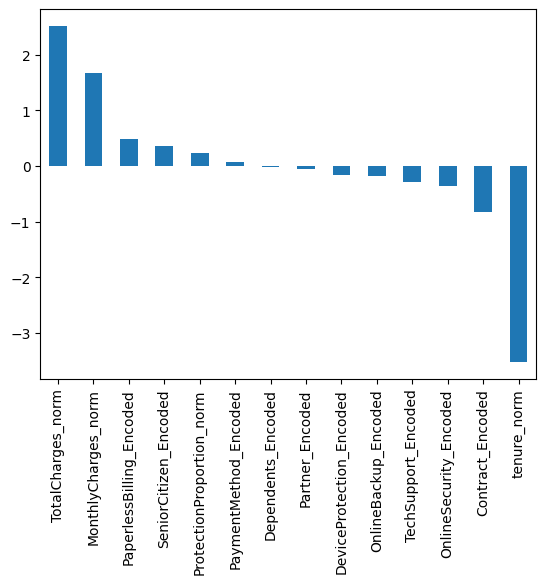

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

lr = LogisticRegression(
    C=4, 
    multi_class='ovr', 
    penalty='l2', 
    solver='lbfgs', 
    class_weight='balanced'
)
result = lr.fit(X_train, y_train)

prediction_test = lr.predict(X_test)
print(accuracy_score(y_test, prediction_test))

weights = pd.Series(lr.coef_[0], index=X_upsample_temp.columns.values)
print(weights.sort_values(ascending = False).plot(kind='bar'))
plt.show()

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

cross_val_scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')

mean_cv_accuracy = cross_val_scores.mean()
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.2f}")

Accuracy Score of Decision Tree is : 0.856682769726248
Confusion Matrix : 
[[1204  332]
 [ 113 1456]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1536
           1       0.81      0.93      0.87      1569

    accuracy                           0.86      3105
   macro avg       0.86      0.86      0.86      3105
weighted avg       0.86      0.86      0.86      3105

Cross-Validation Accuracy Scores: [0.83229814 0.84886128 0.82677709 0.85082873 0.83632597]
Mean Cross-Validation Accuracy: 0.84


0.8837359098228663


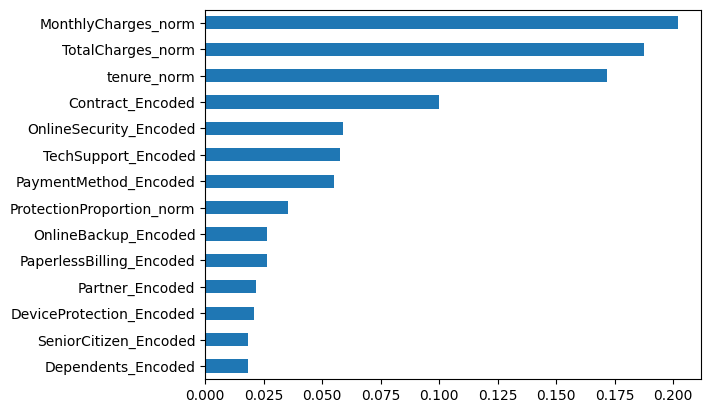

In [20]:
from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(
    n_estimators=200,
    oob_score = True,
    max_features = "auto"
)

rd_clf.fit(X_train, y_train)
prediction_test = rd_clf.predict(X_test)
print(accuracy_score(y_test, prediction_test))

# Finding features importance
importances = rd_clf.feature_importances_
weights = pd.Series(importances, index=X_upsample_temp.columns.values)
weights.sort_values().plot(kind = 'barh')
plt.show()

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(var_smoothing=0.02)
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
conf = confusion_matrix(y_test, y_pred_gnb)
clf_report = classification_report(y_test, y_pred_gnb)

print(f"Accuracy Score of Gaussian Naive Bayes Classifier is: {acc_gnb}")
print(f"Confusion Matrix:\n{conf}")
print(f"Classification Report:\n{clf_report}")

Accuracy Score of Gaussian Naive Bayes Classifier is: 0.744927536231884
Confusion Matrix:
[[1015  521]
 [ 271 1298]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1536
           1       0.71      0.83      0.77      1569

    accuracy                           0.74      3105
   macro avg       0.75      0.74      0.74      3105
weighted avg       0.75      0.74      0.74      3105



Accuracy Score of KNN is : 0.8293075684380032
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1536
           1       0.76      0.96      0.85      1569

    accuracy                           0.83      3105
   macro avg       0.85      0.83      0.83      3105
weighted avg       0.85      0.83      0.83      3105



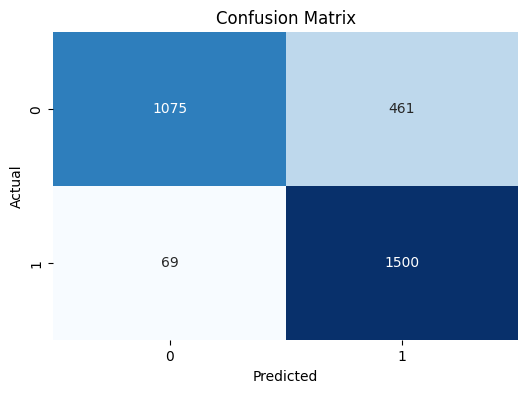

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=13,
    weights='distance',
    algorithm='auto',
    p=2
)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Classification Report : \n{clf_report}")

# Convert the code below into function to display confusion matrix
confusion = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel='linear') 
svm.fit(X_train,y_train)

preds = svm.predict(X_test)
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test,preds)) 

0.7578099838969404
[[1047  489]
 [ 263 1306]]


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.7729468599033816
Confusion Matrix : 
[[1109  427]
 [ 278 1291]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1536
           1       0.75      0.82      0.79      1569

    accuracy                           0.77      3105
   macro avg       0.78      0.77      0.77      3105
weighted avg       0.78      0.77      0.77      3105



In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.5)
ada.fit(X_train,y_train)

preds = ada.predict(X_test)
print(accuracy_score(y_test, preds))

0.7665056360708534


0.8734299516908213
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1536
           1       0.83      0.94      0.88      1569

    accuracy                           0.87      3105
   macro avg       0.88      0.87      0.87      3105
weighted avg       0.88      0.87      0.87      3105



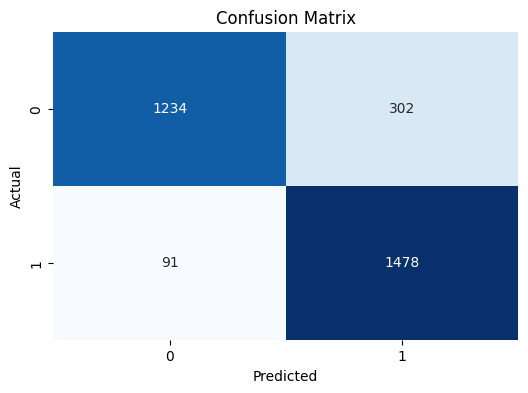

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    max_depth= 10, 
    n_estimators= 300, 
    n_jobs=-1,
    min_child_weight= 1, 
    colsample_bytree= 0.6, 
    gamma= 0.5
)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds))

# Classification Report
class_report = classification_report(y_test, preds)
print(class_report)

# Confusion Matrix
confusion = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.88792
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1536
           1       0.85      0.94      0.89      1569

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



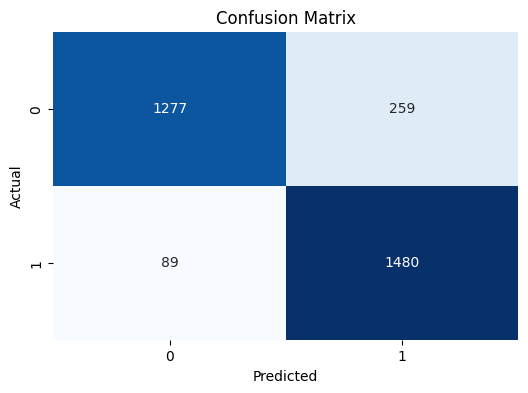

In [27]:
from lightgbm import LGBMClassifier 
from sklearn.metrics import classification_report

lgbm = LGBMClassifier(
    boosting_type='dart', 
    learning_rate=0.65, 
    max_depth=15, 
    min_child_samples=10,       
    n_estimators=400, 
    num_leaves=50, 
    reg_alpha=0.01
)
lgbm.fit(X_train, y_train, verbose=0)

preds = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.5f}")

# Classification Report
class_report = classification_report(y_test, preds)
print(class_report)

# Confusion Matrix
confusion = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from catboost import CatBoostClassifier
from IPython.display import clear_output

cat = CatBoostClassifier(iterations=100, verbose=0)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.7925925925925926
Confusion Matrix : 
[[1137  399]
 [ 245 1324]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1536
           1       0.77      0.84      0.80      1569

    accuracy                           0.79      3105
   macro avg       0.80      0.79      0.79      3105
weighted avg       0.80      0.79      0.79      3105



In [29]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_etc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8898550724637682
Confusion Matrix : 
[[1308  228]
 [ 114 1455]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1536
           1       0.86      0.93      0.89      1569

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [30]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('Gradient Boosting Classifier', gb), 
    ('Cat Boost Classifier', cat), 
    ('XGboost', xgb),  
    ('Decision Tree', dtc),
    ('Extra Tree', etc), 
    ('Light Gradient', lgbm), 
    ('Random Forest', rd_clf), 
    ('Ada Boost', ada), 
    ('Logistic', lr),
    ('Knn', knn)
]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_vtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8766505636070854
Confusion Matrix : 
[[1226  310]
 [  73 1496]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1536
           1       0.83      0.95      0.89      1569

    accuracy                           0.88      3105
   macro avg       0.89      0.88      0.88      3105
weighted avg       0.89      0.88      0.88      3105



### New Dataset with prediction result from top performing model

The top model after hyperparameter tunning are: **ExtraTreesClassifier**, **LGBMClassifier**, **XGBClassifier**, **RandomForestClassifier**, and **DecisionTreeClassifier**. Nonetheless, it still worth trying to include the prediction result from other machine learning model as inputs for the Neural Network Model (MLP).

In [31]:
previous_dataset = X_upsample.drop('Churn_Encoded',axis=1).values
df_updated = X_upsample.copy()

# Top performing model
etc_prediction = etc.predict(previous_dataset)
lgbm_prediction = lgbm.predict(previous_dataset)
xgb_prediction = xgb.predict(previous_dataset)
rd_clf_prediction = rd_clf.predict(previous_dataset)
dtc_prediction = dtc.predict(previous_dataset)

df_updated['etc_pred'] = etc_prediction
df_updated['lgbm_pred'] = lgbm_prediction
df_updated['xgb_pred'] = xgb_prediction
df_updated['rd_clf_pred'] = rd_clf_prediction
df_updated['dtc_pred'] = dtc_prediction

# Other models
# lr_prediction = lr.predict(previous_dataset)
# gnb_prediction = gnb.predict(previous_dataset)
# knn_prediction = knn.predict(previous_dataset)
# svm_prediction = svm.predict(previous_dataset)
# gb_prediction = gb.predict(previous_dataset)
# ada_prediction = ada.predict(previous_dataset)
# cat_prediction = cat.predict(previous_dataset)
# vc_prediction = vc.predict(previous_dataset)

# df_updated['lr_pred'] = lr_prediction
# df_updated['gnb_pred'] = gnb_prediction
# df_updated['lgbm_pred'] = knn_prediction
# df_updated['svm_pred'] = svm_prediction
# df_updated['gb_clf_pred'] = gb_prediction
# df_updated['ada_pred'] = ada_prediction
# df_updated['cat_pred'] = cat_prediction
# df_updated['vc_pred'] = vc_prediction

df_updated.head()

,SeniorCitizen_Encoded,Partner_Encoded,Dependents_Encoded,OnlineSecurity_Encoded,OnlineBackup_Encoded,DeviceProtection_Encoded,TechSupport_Encoded,Contract_Encoded,PaperlessBilling_Encoded,PaymentMethod_Encoded,Churn_Encoded,tenure_norm,MonthlyCharges_norm,TotalCharges_norm,ProtectionProportion_norm,etc_pred,lgbm_pred,xgb_pred,rd_clf_pred,dtc_pred
0,0,1,0,0,2,0,0,0,1,2,0,0.013889,0.115423,0.001275,0.25,0,0,0,0,0
1,0,0,0,2,0,2,0,1,0,3,0,0.472222,0.385075,0.215867,0.50,0,0,0,0,0
3,0,0,0,2,0,2,2,1,0,0,0,0.625000,0.239303,0.210241,0.75,0,0,0,0,0
6,0,0,1,0,2,0,0,0,1,1,0,0.305556,0.704975,0.222779,0.25,0,0,0,0,0
7,0,0,0,2,0,0,0,0,0,3,0,0.138889,0.114428,0.032668,0.25,0,0,0,0,0


In [32]:
model_pred_cols = [
    'etc_pred','lgbm_pred', 'xgb_pred', 'rd_clf_pred', 'dtc_pred', 'lr_pred',
    'gnb_pred', 'svm_pred', 'gb_clf_pred', 'ada_pred', 'cat_pred','vc_pred'
]

X_mlp = df_updated.drop('Churn_Encoded',axis=1)
y_mlp = df_updated['Churn_Encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.3, random_state=0)
print(f'Training Data: {X_train.shape}, {y_train.shape}\nTesting Data: {X_test.shape}, {y_test.shape}')

Training Data: (7243, 19), (7243,)
Testing Data: (3105, 19), (3105,)


In [33]:
import keras 
from keras.layers import Dense, Dropout, LeakyReLU, InputLayer, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
tf.random.set_seed(0)

model = Sequential()
model.add(InputLayer(input_shape=X_train.shape[1]))
# model.add(Dense(27, kernel_regularizer=l2(0.01)))
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.6)) 
# model.add(Dense(240, kernel_regularizer=l2(0.01)))
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.2)) 
model.add(Dense(120, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2)) 
model.add(Dense(60, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2)) 
model.add(Dense(30, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2)) 
# model.add(Dense(15, kernel_regularizer=l2(0.01)))
# model.add(LeakyReLU(alpha=0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               2400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120)               0         
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60)                0         
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1

In [34]:
def create_custom_model(input_shape):
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    
    model.add(Dense(100, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(50, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(input_shape, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.2)) 

    model.add(Dense(1, activation='sigmoid'))
    
    return model

Accuracy:  0.8908212780952454


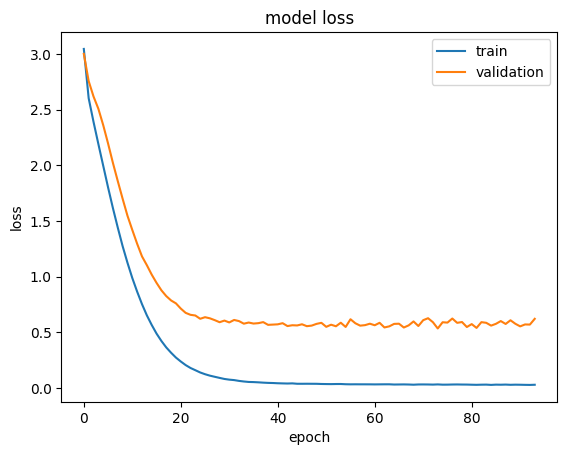

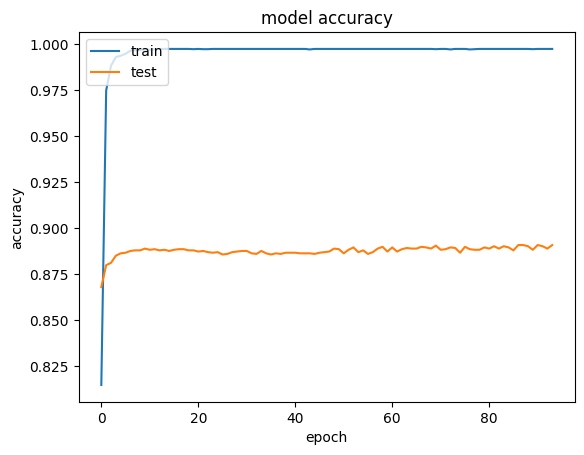

In [35]:
from IPython.display import clear_output
from tensorflow.keras.constraints import max_norm

def create_custom_model(input_shape):
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    
    model.add(Dense(300, kernel_regularizer=l2(0.01), kernel_constraint=max_norm(3.)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    
    model.add(Dense(150, kernel_regularizer=l2(0.01), kernel_constraint=max_norm(3.)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    
    model.add(Dense(input_shape, activation='relu', kernel_regularizer=l2(0.01), kernel_constraint=max_norm(3.)))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model

input_shape = X_train.shape[1]
model = create_custom_model(input_shape)

# input_shape = X_train.shape[1]  # Replace with your input shape
# model = create_modified_model(input_shape, activation_fn='relu', dropout_rate=0.5, use_batch_norm=True, use_residual_connections=True)

model.compile(
    optimizer = Adam(learning_rate=0.0001), # 0.00001
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(
    X_train, y_train, 
    validation_data = (X_test, y_test), 
    batch_size = 64, # 10
    epochs = 150,
    callbacks=[lr_scheduler, early_stopping] 
)

clear_output()

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ", score[1])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()